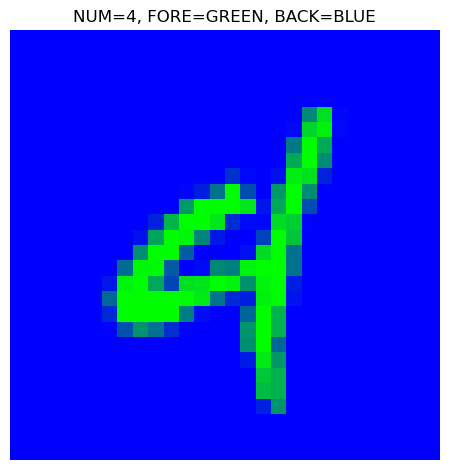

In [1]:
import torch
from torchvision import datasets, transforms
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

np.random.seed(42)  # 난수 생성기의 초기값 설정 (재현성 보장)

# MNIST 데이터셋을 로드합니다.
transform = transforms.Compose([transforms.ToTensor()])
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# 무지개 색상 팔레트를 정의합니다 (7가지 색상).
RAINBOW_COLORS = [
    (255, 0, 0),    # 빨강
    (255, 127, 0),  # 주황
    (255, 255, 0),  # 노랑
    (0, 255, 0),    # 초록
    (0, 0, 255),    # 파랑
    (75, 0, 130),   # 남색 (인디고)
    (148, 0, 211)   # 보라
]

RAINBOW_NAMES = [
    'RED',
    'ORANGE',
    'YELLOW',
    'GREEN',
    'BLUE',
    'INDIGO',
    'VIOLET'
]

def get_random_rainbow_color():
    """무지개 팔레트에서 임의의 색상을 선택합니다."""
    # return tuple(np.random.randint(0, 256, size=3))
    idx = np.random.randint(0, len(RAINBOW_COLORS))
    return RAINBOW_COLORS[idx], RAINBOW_NAMES[idx]

def colorize_digit(digit_image, fg_color, bg_color):
    """숫자 이미지에 전경(fg)과 배경(bg) 색상을 적용합니다."""
    digit = digit_image.convert('L')  # 이미지를 그레이스케일로 변환합니다.
    colored_digit = ImageOps.colorize(digit, black=bg_color, white=fg_color).convert('RGBA')
    return colored_digit

def overlay_digit_on_background(colored_digit):
    """투명도를 제거하고 일관된 배경 이미지를 생성합니다."""
    final_image = colored_digit.convert('RGB')  # 투명도를 제거합니다.
    return final_image

# 전경과 배경 색상이 있는 MNIST 데이터셋을 생성하고 표시합니다.
idx = np.random.randint(0, len(mnist))  # 0~9 사이의 숫자
image, label = mnist[idx]
pil_image = transforms.ToPILImage()(image)

# 전경과 배경 색상을 무작위로 선택합니다.
fg_color, fg_label = get_random_rainbow_color()
bg_color, bg_label = get_random_rainbow_color()

# 전경과 배경 색상이 같지 않도록 보장합니다.
while bg_color == fg_color:
  bg_color, bg_label = get_random_rainbow_color()

# 선택된 색상으로 숫자 이미지를 색칠합니다.
colored_digit = colorize_digit(pil_image, fg_color, bg_color)

if image is not None:
  # 최종 이미지를 표시합니다.
  final_image = overlay_digit_on_background(colored_digit)
  plt.imshow(final_image)
  plt.axis('off')  # 축을 비활성화합니다.
  plt.title(f'NUM={label}, FORE={fg_label}, BACK={bg_label}')

  # 레이아웃을 조정하고 화면에 표시합니다.
  plt.tight_layout()
  plt.show()

In [68]:
import torch
from torchvision import datasets, transforms
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import time

#모델 학습을 위한 데이터 적재
transform = transforms.Compose([transforms.ToTensor()])
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

X_color = []
y_bg = []
y_fg = []
y_digit = []

def get_random_rainbow_color():
    """무지개 팔레트에서 임의의 색상을 선택합니다."""
    # return tuple(np.random.randint(0, 256, size=3))
    idx = np.random.randint(0, len(RAINBOW_COLORS))
    return RAINBOW_COLORS[idx], RAINBOW_NAMES[idx]

def colorize_digit(digit_image, fg_color, bg_color):
    """숫자 이미지에 전경(fg)과 배경(bg) 색상을 적용합니다."""
    digit = digit_image.convert('L')  # 이미지를 그레이스케일로 변환합니다.
    colored_digit = ImageOps.colorize(digit, black=bg_color, white=fg_color).convert('RGB')
    return colored_digit

for i in range(len(mnist)):
    image, label = mnist[i]
    pil_image = transforms.ToPILImage()(image)

    # 전경과 배경 색상을 무작위로 선택합니다.
    fg_color, fg_label = get_random_rainbow_color()
    bg_color, bg_label = get_random_rainbow_color()

    # 전경과 배경 색상이 같지 않도록 보장합니다.
    while bg_color == fg_color:
        bg_color, bg_label = get_random_rainbow_color()

    # 전경 및 배경 색상이 적용된 숫자 이미지를 생성합니다.
    colored_digit = colorize_digit(pil_image, fg_color, bg_color)

    # 결과 이미지를 numpy 배열로 변환하고 리스트에 추가합니다.
    X_color.append(np.array(colored_digit))
    y_digit.append(label)
    y_fg.append(fg_label)
    y_bg.append(bg_label)

#리스트를 Numpy로 변환
X_color = np.array(X_color)
y_digit = np.array(y_digit)
y_fg = np.array(y_fg)
y_bg = np.array(y_bg)

# 데이터 형태를 확인합니다.
print(f"X_color.shape: {X_color.shape}")
print(f"y_digit.shape: {y_digit.shape}")
print(f"y_fg.shape: {y_fg.shape}")
print(f"y_bg.shape: {y_bg.shape}")

# X_color를 (60000, 28, 28, 3)에서 (60000, 2352)로 변환 (flatten)
X_color = np.array(X_color).reshape(-1, 28 * 28 * 3)

# 변환된 X_color_flat의 shape 확인
print(X_color.shape)  # (60000, 2352)

# X_color와 y_fg, y_bg, y_digit에 대한 훈련/검증 세트를 나누기
X_train, X_test = X_color[:50000], X_color[50000:]
y_train_fg, y_test_fg = y_fg[:50000], y_fg[50000:]
y_train_bg, y_test_bg = y_bg[:50000], y_bg[50000:]
y_train_digit, y_test_digit = y_digit[:50000], y_digit[50000:]

# X_train, y_train_fg, y_train_bg, y_train_digit을 한 번에 훈련/검증 세트로 나누기
X_train_split, X_val_split, y_train_fg_split, y_val_fg_split, y_train_bg_split, y_val_bg_split, y_train_digit_split, y_val_digit_split = train_test_split(
    X_train, y_train_fg, y_train_bg, y_train_digit, test_size=0.1, random_state=42
)

# 1. 데이터 분할
# 데이터를 평탄화 (flatten)하여 RandomForest에서 사용할 수 있도록 변환
X_color_flat = X_color.reshape(X_color.shape[0], -1)

# 90% 훈련+검증 / 10% 테스트로 분할
X_train_val, X_test, y_fg_train_val, y_fg_test, y_bg_train_val, y_bg_test, y_digit_train_val, y_digit_test = train_test_split(
    X_color_flat, y_fg, y_bg, y_digit, test_size=0.1, random_state=42
)

# 훈련+검증 데이터를 다시 훈련/검증 세트로 나눔 (90% 훈련 / 10% 검증)
X_train, X_val, y_fg_train, y_fg_val, y_bg_train, y_bg_val, y_digit_train, y_digit_val = train_test_split(
    X_train_val, y_fg_train_val, y_bg_train_val, y_digit_train_val, test_size=0.1, random_state=42
)


# KNN 모델 초기화
knn_fg = KNeighborsClassifier(n_neighbors=5)  # 전경 색상
knn_bg = KNeighborsClassifier(n_neighbors=5)  # 배경 색상
knn_digit = KNeighborsClassifier(n_neighbors=5)  # 숫자

# 학습 및 시간 측정
start_fg = time.time()
knn_fg.fit(X_train, y_fg_train)
end_fg = time.time()

start_bg = time.time()
knn_bg.fit(X_train, y_bg_train)
end_bg = time.time()

start_digit = time.time()
knn_digit.fit(X_train, y_digit_train)
end_digit = time.time()

# 검증 데이터로 예측
val_start_fg = time.time()
y_fg_pred = knn_fg.predict(X_val)
val_end_fg = time.time()

val_start_bg = time.time()
y_bg_pred = knn_bg.predict(X_val)
val_end_bg = time.time()

val_start_digit = time.time()
y_digit_pred = knn_digit.predict(X_val)
val_end_digit = time.time()

# 3. 정확도 계산
accuracy_fg = accuracy_score(y_fg_val, y_fg_pred)
accuracy_bg = accuracy_score(y_bg_val, y_bg_pred)
accuracy_digit = accuracy_score(y_digit_val, y_digit_pred)

# 학습 및 예측 시간 계산
training_time_fg = end_fg - start_fg
training_time_bg = end_bg - start_bg
training_time_digit = end_digit - start_digit

validation_time_fg = val_end_fg - val_start_fg
validation_time_bg = val_end_bg - val_start_bg
validation_time_digit = val_end_digit - val_start_digit

# 4. 결과 출력
print(f"KNN Results")
print(f"KNN 전경 색상(fg) 정확도: {accuracy_fg:.4f}")
print(f"KNN 전경 색상(fg) 학습 시간: {training_time_fg:.2f} 초")
print(f"KNN Validation 전경 색상(fg) 예측 시간: {validation_time_fg:.2f} 초")

print(f"KNN 배경 색상(bg) 정확도: {accuracy_bg:.4f}")
print(f"KNN 배경 색상(bg) 학습 시간: {training_time_bg:.2f} 초")
print(f"KNN Validation 배경 색상(bg) 예측 시간: {validation_time_bg:.2f} 초")

print(f"KNN 숫자(digit) 정확도: {accuracy_digit:.4f}")
print(f"KNN 숫자(digit) 학습 시간: {training_time_digit:.2f} 초")
print(f"KNN Validation 숫자(digit) 예측 시간: {validation_time_digit:.2f} 초")


X_color.shape: (60000, 28, 28, 3)
y_digit.shape: (60000,)
y_fg.shape: (60000,)
y_bg.shape: (60000,)
(60000, 2352)
KNN Results
KNN 전경 색상(fg) 정확도: 0.8491
KNN 전경 색상(fg) 학습 시간: 0.01 초
KNN Validation 전경 색상(fg) 예측 시간: 12.19 초
KNN 배경 색상(bg) 정확도: 1.0000
KNN 배경 색상(bg) 학습 시간: 0.01 초
KNN Validation 배경 색상(bg) 예측 시간: 10.32 초
KNN 숫자(digit) 정확도: 0.8894
KNN 숫자(digit) 학습 시간: 0.00 초
KNN Validation 숫자(digit) 예측 시간: 10.31 초


In [36]:
import numpy as np
from PIL import ImageOps
from torchvision import datasets, transforms
from PIL import Image

# 무작위로 사용할 색상 팔레트 정의
RAINBOW_COLORS = [
    (255, 0, 0),   # Red
    (255, 127, 0), # Orange
    (255, 255, 0), # Yellow
    (0, 255, 0),   # Green
    (0, 0, 255),   # Blue
    (75, 0, 130),  # Indigo
    (143, 0, 255)  # Violet
]
RAINBOW_NAMES = ["Red", "Orange", "Yellow", "Green", "Blue", "Indigo", "Violet"]

# 데이터 적재
transform = transforms.Compose([transforms.ToTensor()])
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

X_color = []
y_bg = []
y_fg = []
y_digit = []

# 무작위 색상 선택 함수
def get_random_rainbow_color():
    idx = np.random.randint(0, len(RAINBOW_COLORS))
    return RAINBOW_COLORS[idx], RAINBOW_NAMES[idx]

# 이진화 후 색상을 입히는 함수
def colorize_digit(digit_image, fg_color, bg_color):
    """숫자 이미지에 이진화 후 전경(fg)과 배경(bg) 색상을 적용합니다."""
    # 이미지를 그레이스케일로 변환 및 이진화
    digit = digit_image.convert('L')
    threshold = 127
    digit = digit.point(lambda p: 255 if p > threshold else 0)  # 이진화 적용

    # 전경과 배경 색상 적용
    colored_digit = ImageOps.colorize(digit, black=bg_color, white=fg_color).convert('RGB')
    return colored_digit

# 데이터셋에 색상을 입히고 전처리
for i in range(len(mnist)):
    image, label = mnist[i]
    pil_image = transforms.ToPILImage()(image)

    # 전경과 배경 색상 선택 (서로 다른 색상으로 설정)
    fg_color, fg_label = get_random_rainbow_color()
    bg_color, bg_label = get_random_rainbow_color()

    while bg_color == fg_color:
        bg_color, bg_label = get_random_rainbow_color()

    # 이진화 후 전경 및 배경 색상이 적용된 숫자 이미지 생성
    colored_digit = colorize_digit(pil_image, fg_color, bg_color)

    # 결과 이미지를 numpy 배열로 변환하고 리스트에 추가
    X_color.append(np.array(colored_digit))
    y_digit.append(label)
    y_fg.append(fg_label)
    y_bg.append(bg_label)

# 리스트를 Numpy 배열로 변환
X_color = np.array(X_color)
y_digit = np.array(y_digit)
y_fg = np.array(y_fg)
y_bg = np.array(y_bg)

# 데이터 형태를 확인
print(f"X_color.shape: {X_color.shape}")
print(f"y_digit.shape: {y_digit.shape}")
print(f"y_fg.shape: {y_fg.shape}")
print(f"y_bg.shape: {y_bg.shape}")


X_color.shape: (60000, 28, 28, 3)
y_digit.shape: (60000,)
y_fg.shape: (60000,)
y_bg.shape: (60000,)


In [37]:
X_color_flat = X_color.reshape(X_color.shape[0], -1)

# 90% 훈련+검증 / 10% 테스트로 분할
X_train_val, X_test, y_fg_train_val, y_fg_test, y_bg_train_val, y_bg_test, y_digit_train_val, y_digit_test = train_test_split(
    X_color_flat, y_fg, y_bg, y_digit, test_size=0.1, random_state=42
)

# 훈련+검증 데이터를 다시 훈련/검증 세트로 나눔 (90% 훈련 / 10% 검증)
X_train, X_val, y_fg_train, y_fg_val, y_bg_train, y_bg_val, y_digit_train, y_digit_val = train_test_split(
    X_train_val, y_fg_train_val, y_bg_train_val, y_digit_train_val, test_size=0.1, random_state=42
)

In [38]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import time

# KNN 모델 초기화
knn_fg = KNeighborsClassifier(n_neighbors=5)  # 전경 색상
knn_bg = KNeighborsClassifier(n_neighbors=5)  # 배경 색상
knn_digit = KNeighborsClassifier(n_neighbors=5)  # 숫자

# 학습 및 시간 측정
start_fg = time.time()
knn_fg.fit(X_train, y_fg_train)
end_fg = time.time()

start_bg = time.time()
knn_bg.fit(X_train, y_bg_train)
end_bg = time.time()

start_digit = time.time()
knn_digit.fit(X_train, y_digit_train)
end_digit = time.time()

# 검증 데이터로 예측
val_start_fg = time.time()
y_fg_pred = knn_fg.predict(X_val)
val_end_fg = time.time()

val_start_bg = time.time()
y_bg_pred = knn_bg.predict(X_val)
val_end_bg = time.time()

val_start_digit = time.time()
y_digit_pred = knn_digit.predict(X_val)
val_end_digit = time.time()

# 3. 정확도 계산
accuracy_fg_knn_binarization = accuracy_score(y_fg_val, y_fg_pred)
accuracy_bg_knn_binarization = accuracy_score(y_bg_val, y_bg_pred)
accuracy_digit_knn_binarization = accuracy_score(y_digit_val, y_digit_pred)

# 학습 및 예측 시간 계산
training_time_fg_knn_binarization = end_fg - start_fg
training_time_bg_knn_binarization = end_bg - start_bg
training_time_digit_knn_binarization = end_digit - start_digit

validation_time_fg_knn_binarization = val_end_fg - val_start_fg
validation_time_bg_knn_binarization = val_end_bg - val_start_bg
validation_time_digit_knn_binarization = val_end_digit - val_start_digit

# 4. 결과 출력
print(f"KNN Results")
print(f"KNN 전경 색상(fg) 정확도: {accuracy_fg_knn_binarization:.4f}")
print(f"KNN 전경 색상(fg) 학습 시간: {training_time_fg_knn_binarization:.2f} 초")
print(f"KNN Validation 전경 색상(fg) 예측 시간: {validation_time_fg_knn_binarization:.2f} 초")

print(f"KNN 배경 색상(bg) 정확도: {accuracy_bg_knn_binarization:.4f}")
print(f"KNN 배경 색상(bg) 학습 시간: {training_time_bg_knn_binarization:.2f} 초")
print(f"KNN Validation 배경 색상(bg) 예측 시간: {validation_time_bg_knn_binarization:.2f} 초")

print(f"KNN 숫자(digit) 정확도: {accuracy_digit_knn_binarization:.4f}")
print(f"KNN 숫자(digit) 학습 시간: {training_time_digit_knn_binarization:.2f} 초")
print(f"KNN Validation 숫자(digit) 예측 시간: {validation_time_digit_knn_binarization:.2f} 초")


KNN Results
KNN 전경 색상(fg) 정확도: 0.7650
KNN 전경 색상(fg) 학습 시간: 0.02 초
KNN Validation 전경 색상(fg) 예측 시간: 10.34 초
KNN 배경 색상(bg) 정확도: 1.0000
KNN 배경 색상(bg) 학습 시간: 0.01 초
KNN Validation 배경 색상(bg) 예측 시간: 10.73 초
KNN 숫자(digit) 정확도: 0.8711
KNN 숫자(digit) 학습 시간: 0.00 초
KNN Validation 숫자(digit) 예측 시간: 10.18 초


In [60]:
X_color = []
y_bg = []
y_fg = []
y_digit = []

for i in range(len(mnist)):
    image, label = mnist[i]
    pil_image = transforms.ToPILImage()(image)

    # 전경과 배경 색상을 무작위로 선택합니다.
    fg_color, fg_label = get_random_rainbow_color()
    bg_color, bg_label = get_random_rainbow_color()

    # 전경과 배경 색상이 같지 않도록 보장합니다.
    while bg_color == fg_color:
        bg_color, bg_label = get_random_rainbow_color()

    # 전경 및 배경 색상이 적용된 숫자 이미지를 생성합니다.
    colored_digit = colorize_digit(pil_image, fg_color, bg_color)

    # 결과 이미지를 numpy 배열로 변환하고 리스트에 추가합니다.
    X_color.append(np.array(colored_digit))
    y_digit.append(label)
    y_fg.append(fg_label)
    y_bg.append(bg_label)
#리스트를 Numpy로 변환
X_color = np.array(X_color)
y_digit = np.array(y_digit)
y_fg = np.array(y_fg)
y_bg = np.array(y_bg)


In [61]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# 데이터 평탄화 (flatten)
X_color_flattened = X_color.reshape(-1, 28 * 28 * 3)

# 훈련, 테스트 데이터 분할 (90% 훈련+검증, 10% 테스트)
X_train_val, X_test, y_fg_train_val, y_fg_test, y_bg_train_val, y_bg_test, y_digit_train_val, y_digit_test = train_test_split(
    X_color_flattened, y_fg, y_bg, y_digit, test_size=0.1, random_state=42
)

# 훈련, 검증 데이터 분할 (90% 훈련, 10% 검증)
X_train, X_val, y_fg_train, y_fg_val, y_bg_train, y_bg_val, y_digit_train, y_digit_val = train_test_split(
    X_train_val, y_fg_train_val, y_bg_train_val, y_digit_train_val, test_size=0.1, random_state=42
)

# 정규화 (훈련 데이터 기준으로 fit)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# 최종 데이터 형태 확인
print(f"훈련 데이터 크기: {X_train_scaled.shape}")
print(f"검증 데이터 크기: {X_val_scaled.shape}")
print(f"테스트 데이터 크기: {X_test_scaled.shape}")


훈련 데이터 크기: (48600, 2352)
검증 데이터 크기: (5400, 2352)
테스트 데이터 크기: (6000, 2352)


In [66]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import time

# KNN 모델 초기화
knn_model_fg = KNeighborsClassifier(n_neighbors=5)
knn_model_bg = KNeighborsClassifier(n_neighbors=5)
knn_model_digit = KNeighborsClassifier(n_neighbors=5)

# 모델 학습
start_time_fg = time.time()
knn_model_fg.fit(X_train_scaled, y_fg_train)
end_time_fg = time.time()

start_time_bg = time.time()
knn_model_bg.fit(X_train_scaled, y_bg_train)
end_time_bg = time.time()

start_time_digit = time.time()
knn_model_digit.fit(X_train_scaled, y_digit_train)
end_time_digit = time.time()

# 검증 데이터로 예측
start_time_fg_val = time.time()
y_val_fg_pred = knn_model_fg.predict(X_val_scaled)
end_time_fg_val = time.time()

start_time_bg_val = time.time()
y_val_bg_pred = knn_model_bg.predict(X_val_scaled)
end_time_bg_val = time.time()

start_time_digit_val = time.time()
y_val_digit_pred = knn_model_digit.predict(X_val_scaled)
end_time_digit_val = time.time()

# 학습 및 예측 시간 계산
training_time_fg_MinMax = end_time_fg - start_time_fg
training_time_bg_MinMax = end_time_bg - start_time_bg
training_time_digit_MinMax = end_time_digit - start_time_digit

validation_time_fg_MinMax = end_time_fg_val - start_time_fg_val
validation_time_bg_MinMax = end_time_bg_val - start_time_bg_val
validation_time_digit_MinMax = end_time_digit_val - start_time_digit_val

# 정확도 계산
accuracy_fg_knn_MinMax = accuracy_score(y_fg_val, y_val_fg_pred)
accuracy_bg_knn_MinMax = accuracy_score(y_bg_val, y_val_bg_pred)
accuracy_digit_knn_MinMax = accuracy_score(y_digit_val, y_val_digit_pred)

# 결과 출력
print(f"Data Min-Max Scaling with KNN")
print(f"KNN 전경 색상(fg) 정확도: {accuracy_fg_knn_MinMax:.4f}")
print(f"KNN 전경 색상(fg) 학습 시간: {training_time_fg_MinMax:.2f} 초")
print(f"KNN Validation 전경 색상(fg) 예측 시간: {validation_time_fg_MinMax:.2f} 초")

print(f"KNN 배경 색상(bg) 정확도: {accuracy_bg_knn_MinMax:.4f}")
print(f"KNN 배경 색상(bg) 학습 시간: {training_time_bg_MinMax:.2f} 초")
print(f"KNN Validation 배경 색상(bg) 예측 시간: {validation_time_bg_MinMax:.2f} 초")

print(f"KNN 숫자(digit) 정확도: {accuracy_digit_knn_MinMax:.4f}")
print(f"KNN 숫자(digit) 학습 시간: {training_time_digit_MinMax:.2f} 초")
print(f"KNN Validation 숫자(digit) 예측 시간: {validation_time_digit_MinMax:.2f} 초")



Data Min-Max Scaling with KNN
KNN 전경 색상(fg) 정확도: 0.7617
KNN 전경 색상(fg) 학습 시간: 0.20 초
KNN Validation 전경 색상(fg) 예측 시간: 5.15 초
KNN 배경 색상(bg) 정확도: 1.0000
KNN 배경 색상(bg) 학습 시간: 0.16 초
KNN Validation 배경 색상(bg) 예측 시간: 5.21 초
KNN 숫자(digit) 정확도: 0.8763
KNN 숫자(digit) 학습 시간: 0.14 초
KNN Validation 숫자(digit) 예측 시간: 5.03 초


In [69]:
X_color = []
y_bg = []
y_fg = []
y_digit = []

for i in range(len(mnist)):
    image, label = mnist[i]
    pil_image = transforms.ToPILImage()(image)

    # 전경과 배경 색상을 무작위로 선택합니다.
    fg_color, fg_label = get_random_rainbow_color()
    bg_color, bg_label = get_random_rainbow_color()

    # 전경과 배경 색상이 같지 않도록 보장합니다.
    while bg_color == fg_color:
        bg_color, bg_label = get_random_rainbow_color()

    # 전경 및 배경 색상이 적용된 숫자 이미지를 생성합니다.
    colored_digit = colorize_digit(pil_image, fg_color, bg_color)

    # 결과 이미지를 numpy 배열로 변환하고 리스트에 추가합니다.
    X_color.append(np.array(colored_digit))
    y_digit.append(label)
    y_fg.append(fg_label)
    y_bg.append(bg_label)
#리스트를 Numpy로 변환
X_color = np.array(X_color)
y_digit = np.array(y_digit)
y_fg = np.array(y_fg)
y_bg = np.array(y_bg)


In [29]:
# X_color 배열을 그레이스케일로 변환
X_color_gray = []

for img in X_color:
    # RGB 이미지를 Grayscale로 변환
    gray_image = Image.fromarray(img).convert('L')
    X_color_gray.append(np.array(gray_image))

X_color_gray = np.array(X_color_gray)

In [30]:
X_color_gray_flat = X_color_gray.reshape(X_color_gray.shape[0], -1)

# 2. 데이터 분할
# 90% 훈련+검증 / 10% 테스트로 분할
X_train_val, X_test, y_fg_train_val, y_fg_test, y_bg_train_val, y_bg_test, y_digit_train_val, y_digit_test = train_test_split(
    X_color_gray_flat, y_fg, y_bg, y_digit, test_size=0.1, random_state=42
)

# 훈련+검증 데이터를 다시 훈련/검증 세트로 나눔 (90% 훈련 / 10% 검증)
X_train, X_val, y_fg_train, y_fg_val, y_bg_train, y_bg_val, y_digit_train, y_digit_val = train_test_split(
    X_train_val, y_fg_train_val, y_bg_train_val, y_digit_train_val, test_size=0.1, random_state=42
)



In [31]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import time

# KNN 모델 초기화
knn_fg = KNeighborsClassifier(n_neighbors=5)  # 전경 색상(fg)
knn_bg = KNeighborsClassifier(n_neighbors=5)  # 배경 색상(bg)
knn_digit = KNeighborsClassifier(n_neighbors=5)  # 숫자(digit)

# 학습 및 시간 측정 - 전경 색상(fg)
start_fg = time.time()
knn_fg.fit(X_train, y_fg_train)
end_fg = time.time()

# 학습 및 시간 측정 - 배경 색상(bg)
start_bg = time.time()
knn_bg.fit(X_train, y_bg_train)
end_bg = time.time()

# 학습 및 시간 측정 - 숫자(digit)
start_digit = time.time()
knn_digit.fit(X_train, y_digit_train)
end_digit = time.time()

# 검증 데이터로 예측
val_start_fg = time.time()
y_fg_pred = knn_fg.predict(X_val)
val_end_fg = time.time()

val_start_bg = time.time()
y_bg_pred = knn_bg.predict(X_val)
val_end_bg = time.time()

val_start_digit = time.time()
y_digit_pred = knn_digit.predict(X_val)
val_end_digit = time.time()

# 5. 정확도 계산
accuracy_fg_grayscale_knn = accuracy_score(y_fg_val, y_fg_pred)
accuracy_bg_grayscale_knn = accuracy_score(y_bg_val, y_bg_pred)
accuracy_digit_grayscale_knn = accuracy_score(y_digit_val, y_digit_pred)

# 학습 및 예측 시간 계산
training_time_fg_grayscale_knn = end_fg - start_fg
training_time_bg_grayscale_knn = end_bg - start_bg
training_time_digit_grayscale_knn = end_digit - start_digit

validation_time_fg_grayscale_knn = val_end_fg - val_start_fg
validation_time_bg_grayscale_knn = val_end_bg - val_start_bg
validation_time_digit_grayscale_knn = val_end_digit - val_start_digit

# 6. 결과 출력
print(f"KNN with Data Gray Scale")
print(f"KNN 전경 색상(fg) 정확도: {accuracy_fg_grayscale_knn:.4f}")
print(f"KNN 전경 색상(fg) 학습 시간: {training_time_fg_grayscale_knn:.2f} 초")
print(f"KNN Validation 전경 색상(fg) 예측 시간: {validation_time_fg_grayscale_knn:.2f} 초")

print(f"KNN 배경 색상(bg) 정확도: {accuracy_bg_grayscale_knn:.4f}")
print(f"KNN 배경 색상(bg) 학습 시간: {training_time_bg_grayscale_knn:.2f} 초")
print(f"KNN Validation 배경 색상(bg) 예측 시간: {validation_time_bg_grayscale_knn:.2f} 초")

print(f"KNN 숫자(digit) 정확도: {accuracy_digit_grayscale_knn:.4f}")
print(f"KNN 숫자(digit) 학습 시간: {training_time_digit_grayscale_knn:.2f} 초")
print(f"KNN Validation 숫자(digit) 예측 시간: {validation_time_digit_grayscale_knn:.2f} 초")


KNN with Data Gray Scale
KNN 전경 색상(fg) 정확도: 0.4735
KNN 전경 색상(fg) 학습 시간: 0.01 초
KNN Validation 전경 색상(fg) 예측 시간: 6.13 초
KNN 배경 색상(bg) 정확도: 0.7520
KNN 배경 색상(bg) 학습 시간: 0.01 초
KNN Validation 배경 색상(bg) 예측 시간: 6.20 초
KNN 숫자(digit) 정확도: 0.9006
KNN 숫자(digit) 학습 시간: 0.00 초
KNN Validation 숫자(digit) 예측 시간: 6.26 초


In [42]:
print(f"KNN Raw Results")
print(f"KNN 전경 색상(fg) 정확도: {accuracy_fg:.4f}")
print(f"KNN 전경 색상(fg) 학습 시간: {training_time_fg:.2f} 초")
print(f"KNN Validation 전경 색상(fg) 예측 시간: {validation_time_fg:.2f} 초")

print(f"KNN 배경 색상(bg) 정확도: {accuracy_bg:.4f}")
print(f"KNN 배경 색상(bg) 학습 시간: {training_time_bg:.2f} 초")
print(f"KNN Validation 배경 색상(bg) 예측 시간: {validation_time_bg:.2f} 초")

print(f"KNN 숫자(digit) 정확도: {accuracy_digit:.4f}")
print(f"KNN 숫자(digit) 학습 시간: {training_time_digit:.2f} 초")
print(f"KNN Validation 숫자(digit) 예측 시간: {validation_time_digit:.2f} 초")

print(f"KNN Binarization Results")
print(f"KNN 전경 색상(fg) 정확도: {accuracy_fg_knn_binarization:.4f}")
print(f"KNN 전경 색상(fg) 학습 시간: {training_time_fg_knn_binarization:.2f} 초")
print(f"KNN Validation 전경 색상(fg) 예측 시간: {validation_time_fg_knn_binarization:.2f} 초")

print(f"KNN 배경 색상(bg) 정확도: {accuracy_bg_knn_binarization:.4f}")
print(f"KNN 배경 색상(bg) 학습 시간: {training_time_bg_knn_binarization:.2f} 초")
print(f"KNN Validation 배경 색상(bg) 예측 시간: {validation_time_bg_knn_binarization:.2f} 초")

print(f"KNN 숫자(digit) 정확도: {accuracy_digit_knn_binarization:.4f}")
print(f"KNN 숫자(digit) 학습 시간: {training_time_digit_knn_binarization:.2f} 초")
print(f"KNN Validation 숫자(digit) 예측 시간: {validation_time_digit_knn_binarization:.2f} 초")

print(f"Data Min-Max Scaling with KNN")
print(f"KNN 전경 색상(fg) 정확도: {accuracy_fg_knn_MinMax:.4f}")
print(f"KNN 전경 색상(fg) 학습 시간: {training_time_fg_MinMax:.2f} 초")
print(f"KNN Validation 전경 색상(fg) 예측 시간: {training_time_fg_val_MinMax:.2f} 초")

print(f"KNN 배경 색상(bg) 정확도: {accuracy_bg_knn_MinMax:.4f}")
print(f"KNN 배경 색상(bg) 학습 시간: {training_time_bg_MinMax:.2f} 초")
print(f"KNN Validation 배경 색상(bg) 예측 시간: {training_time_bg_val_MinMax:.2f} 초")

print(f"KNN 숫자(digit) 정확도: {accuracy_digit_knn_MinMax:.4f}")
print(f"KNN 숫자(digit) 학습 시간: {training_time_digit_MinMax:.2f} 초")
print(f"KNN Validation 숫자(digit) 예측 시간: {training_time_digit_val_MinMax:.2f} 초")

print(f"KNN with Data Gray Scale")
print(f"KNN 전경 색상(fg) 정확도: {accuracy_fg_grayscale_knn:.4f}")
print(f"KNN 전경 색상(fg) 학습 시간: {training_time_fg_grayscale_knn:.2f} 초")
print(f"KNN Validation 전경 색상(fg) 예측 시간: {validation_time_fg_grayscale_knn:.2f} 초")

print(f"KNN 배경 색상(bg) 정확도: {accuracy_bg_grayscale_knn:.4f}")
print(f"KNN 배경 색상(bg) 학습 시간: {training_time_bg_grayscale_knn:.2f} 초")
print(f"KNN Validation 배경 색상(bg) 예측 시간: {validation_time_bg_grayscale_knn:.2f} 초")

print(f"KNN 숫자(digit) 정확도: {accuracy_digit_grayscale_knn:.4f}")
print(f"KNN 숫자(digit) 학습 시간: {training_time_digit_grayscale_knn:.2f} 초")
print(f"KNN Validation 숫자(digit) 예측 시간: {validation_time_digit_grayscale_knn:.2f} 초")

KNN Raw Results
KNN 전경 색상(fg) 정확도: 0.8470
KNN 전경 색상(fg) 학습 시간: 0.01 초
KNN Validation 전경 색상(fg) 예측 시간: 9.86 초
KNN 배경 색상(bg) 정확도: 1.0000
KNN 배경 색상(bg) 학습 시간: 0.01 초
KNN Validation 배경 색상(bg) 예측 시간: 9.77 초
KNN 숫자(digit) 정확도: 0.8930
KNN 숫자(digit) 학습 시간: 0.00 초
KNN Validation 숫자(digit) 예측 시간: 9.69 초
KNN Binarization Results
KNN 전경 색상(fg) 정확도: 0.7650
KNN 전경 색상(fg) 학습 시간: 0.02 초
KNN Validation 전경 색상(fg) 예측 시간: 10.34 초
KNN 배경 색상(bg) 정확도: 1.0000
KNN 배경 색상(bg) 학습 시간: 0.01 초
KNN Validation 배경 색상(bg) 예측 시간: 10.73 초
KNN 숫자(digit) 정확도: 0.8711
KNN 숫자(digit) 학습 시간: 0.00 초
KNN Validation 숫자(digit) 예측 시간: 10.18 초
Data Min-Max Scaling with KNN
KNN 전경 색상(fg) 정확도: 0.7646
KNN 전경 색상(fg) 학습 시간: 0.14 초
KNN Validation 전경 색상(fg) 예측 시간: 4.96 초
KNN 배경 색상(bg) 정확도: 1.0000
KNN 배경 색상(bg) 학습 시간: 0.14 초
KNN Validation 배경 색상(bg) 예측 시간: 4.61 초
KNN 숫자(digit) 정확도: 0.8648
KNN 숫자(digit) 학습 시간: 0.13 초
KNN Validation 숫자(digit) 예측 시간: 5.36 초
KNN with Data Gray Scale
KNN 전경 색상(fg) 정확도: 0.4735
KNN 전경 색상(fg) 학습 시간: 0.01 초
KNN Valida

In [70]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import time
from PIL import Image

# 1. 데이터 준비 및 Grayscale 변환
# X_color 데이터를 Grayscale로 변환
X_color_gray = []
for img in X_color:
    gray_image = Image.fromarray(img).convert('L')
    X_color_gray.append(np.array(gray_image))

X_color_gray = np.array(X_color_gray)

# 평탄화 (flatten)하여 (n_samples, height * width)
X_color_gray_flat = X_color_gray.reshape(X_color_gray.shape[0], -1)

# 2. 데이터 분할
# 90% 훈련+검증 / 10% 테스트로 분할
X_train_val, X_test, y_fg_train_val, y_fg_test, y_bg_train_val, y_bg_test, y_digit_train_val, y_digit_test = train_test_split(
    X_color_gray_flat, y_fg, y_bg, y_digit, test_size=0.1, random_state=42
)

# 훈련+검증 데이터를 다시 훈련/검증 세트로 나눔 (90% 훈련 / 10% 검증)
X_train, X_val, y_fg_train, y_fg_val, y_bg_train, y_bg_val, y_digit_train, y_digit_val = train_test_split(
    X_train_val, y_fg_train_val, y_bg_train_val, y_digit_train_val, test_size=0.1, random_state=42
)

# 3. MinMax Scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# 4. KNN 모델 학습
knn_model_fg = KNeighborsClassifier(n_neighbors=5)
knn_model_bg = KNeighborsClassifier(n_neighbors=5)
knn_model_digit = KNeighborsClassifier(n_neighbors=5)

# 전경 색상(fg) 학습
start_time_fg = time.time()
knn_model_fg.fit(X_train_scaled, y_fg_train)
end_time_fg = time.time()

# 배경 색상(bg) 학습
start_time_bg = time.time()
knn_model_bg.fit(X_train_scaled, y_bg_train)
end_time_bg = time.time()

# 숫자(digit) 학습
start_time_digit = time.time()
knn_model_digit.fit(X_train_scaled, y_digit_train)
end_time_digit = time.time()

# 5. 검증 데이터로 예측
start_time_fg_val = time.time()
y_val_fg_pred = knn_model_fg.predict(X_val_scaled)
end_time_fg_val = time.time()

start_time_bg_val = time.time()
y_val_bg_pred = knn_model_bg.predict(X_val_scaled)
end_time_bg_val = time.time()

start_time_digit_val = time.time()
y_val_digit_pred = knn_model_digit.predict(X_val_scaled)
end_time_digit_val = time.time()

# 6. 학습 및 예측 시간 계산
training_time_fg_MinMaxGray = end_time_fg - start_time_fg
training_time_bg_MinMaxGray = end_time_bg - start_time_bg
training_time_digit_MinMaxGray = end_time_digit - start_time_digit

validation_time_fg_MinMaxGray = end_time_fg_val - start_time_fg_val
validation_time_bg_MinMaxGray = end_time_bg_val - start_time_bg_val
validation_time_digit_MinMaxGray = end_time_digit_val - start_time_digit_val

# 7. 정확도 계산
accuracy_fg_knn_MinMaxGray = accuracy_score(y_fg_val, y_val_fg_pred)
accuracy_bg_knn_MinMaxGray = accuracy_score(y_bg_val, y_val_bg_pred)
accuracy_digit_knn_MinMaxGray = accuracy_score(y_digit_val, y_val_digit_pred)

# 8. 결과 출력
print(f"Data Min-Max Scaling + Grayscale with KNN")
print(f"KNN 전경 색상(fg) 정확도: {accuracy_fg_knn_MinMaxGray:.4f}")
print(f"KNN 전경 색상(fg) 학습 시간: {training_time_fg_MinMaxGray:.2f} 초")
print(f"KNN Validation 전경 색상(fg) 예측 시간: {validation_time_fg_MinMaxGray:.2f} 초")

print(f"KNN 배경 색상(bg) 정확도: {accuracy_bg_knn_MinMaxGray:.4f}")
print(f"KNN 배경 색상(bg) 학습 시간: {training_time_bg_MinMaxGray:.2f} 초")
print(f"KNN Validation 배경 색상(bg) 예측 시간: {validation_time_bg_MinMaxGray:.2f} 초")

print(f"KNN 숫자(digit) 정확도: {accuracy_digit_knn_MinMaxGray:.4f}")
print(f"KNN 숫자(digit) 학습 시간: {training_time_digit_MinMaxGray:.2f} 초")
print(f"KNN Validation 숫자(digit) 예측 시간: {validation_time_digit_MinMaxGray:.2f} 초")


Data Min-Max Scaling + Grayscale with KNN
KNN 전경 색상(fg) 정확도: 0.5441
KNN 전경 색상(fg) 학습 시간: 0.07 초
KNN Validation 전경 색상(fg) 예측 시간: 1.90 초
KNN 배경 색상(bg) 정확도: 0.7663
KNN 배경 색상(bg) 학습 시간: 0.06 초
KNN Validation 배경 색상(bg) 예측 시간: 2.05 초
KNN 숫자(digit) 정확도: 0.9083
KNN 숫자(digit) 학습 시간: 0.05 초
KNN Validation 숫자(digit) 예측 시간: 1.92 초
